# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
import statsmodels.api as sm
from datetime import datetime, time

# Load Data

In [2]:
trades = pd.read_csv("PXA.X 20250115 Stocks Trades.csv")
trades["Date-Time"] = pd.to_datetime(trades["Date-Time"])

In [3]:
lob = pd.read_csv("PXA.X 20250115 Market Depth Legacy x 10.csv")
lob["Date-Time"] = pd.to_datetime(lob["Date-Time"])
print(lob.shape)
lob.columns

(24996, 65)


Index(['#RIC', 'Domain', 'Date-Time', 'Type', 'L1-BidPrice', 'L2-BidPrice',
       'L3-BidPrice', 'L4-BidPrice', 'L5-BidPrice', 'L6-BidPrice',
       'L7-BidPrice', 'L8-BidPrice', 'L9-BidPrice', 'L10-BidPrice',
       'L1-BidSize', 'L2-BidSize', 'L3-BidSize', 'L4-BidSize', 'L5-BidSize',
       'L6-BidSize', 'L7-BidSize', 'L8-BidSize', 'L9-BidSize', 'L10-BidSize',
       'L1-BuyNo', 'L2-BuyNo', 'L3-BuyNo', 'L4-BuyNo', 'L5-BuyNo', 'L6-BuyNo',
       'L7-BuyNo', 'L8-BuyNo', 'L9-BuyNo', 'L10-BuyNo', 'L1-AskPrice',
       'L2-AskPrice', 'L3-AskPrice', 'L4-AskPrice', 'L5-AskPrice',
       'L6-AskPrice', 'L7-AskPrice', 'L8-AskPrice', 'L9-AskPrice',
       'L10-AskPrice', 'L1-AskSize', 'L2-AskSize', 'L3-AskSize', 'L4-AskSize',
       'L5-AskSize', 'L6-AskSize', 'L7-AskSize', 'L8-AskSize', 'L9-AskSize',
       'L10-AskSize', 'L1-SellNo', 'L2-SellNo', 'L3-SellNo', 'L4-SellNo',
       'L5-SellNo', 'L6-SellNo', 'L7-SellNo', 'L8-SellNo', 'L9-SellNo',
       'L10-SellNo', 'Exch Time'],
      dtype='

# Data Processing

In [4]:
# Extracting time component only
trades['Date-Time'] = pd.to_datetime(trades['Date-Time'])
trades['Time'] = trades['Date-Time'].dt.time

# Filter trades by time
start_time = time(10, 10, 0)  # 10:10:00 AM
end_time = time(16, 0, 0)     # 16:00:00 PM
filtered_trades = trades[trades['Time'] >= start_time]
filtered_trades = filtered_trades[filtered_trades["Time"] <= end_time]
filtered_trades = filtered_trades.sort_values(by="Time")


# Extracting time component only
lob['Date-Time'] = pd.to_datetime(lob['Date-Time'])
lob['Time'] = lob['Date-Time'].dt.time

# Filter trades by time
start_time = time(10, 10, 0)  # 10:10:00 AM
end_time = time(16, 0, 0)     # 16:00:00 PM
lob = lob[lob['Time'] >= start_time]
lob = lob[lob["Time"] <= end_time]
lob = lob.sort_values(by="Time")
lob = lob.reset_index()
lob["LOB_Index"] = lob.index

In [5]:
levels = range(1, 11)  # 1 to 10

# Calculate bid-ask spread at each level
for level in levels:
    bid_col = f"L{level}-BidPrice"
    ask_col = f"L{level}-AskPrice"
    spread_col = f"L{level}-Spread"

    bidsize_col = f"L{level}-BidSize"
    asksize_col = f"L{level}-AskSize"

    midprice1_col = f"L{level}-MidPrice_Simple"
    midprice2_col = f"L{level}-MidPrice_VW"
    midprice3_col = f"L{level}-MidPrice_SCVW"

    cum_bid_col = f"L{level}-CumBidDepth"
    cum_ask_col = f"L{level}-CumAskDepth"
    depth_imb_col = f"L{level}-DepthImbalance"
    min_depth_col = f"L{level}-MinDepth"

    # Ensure columns exist in the dataset before calculating
    if bid_col in lob.columns and ask_col in lob.columns:
        lob[spread_col] = lob[ask_col] - lob[bid_col]
        lob[midprice1_col] = (lob[bid_col] + lob[ask_col]) / 2
        lob[midprice2_col] = ( (lob[bid_col] * lob[bidsize_col])  + (lob[ask_col] * lob[asksize_col]) ) / (lob[bidsize_col] + lob[asksize_col])
        lob[midprice3_col] = ( (lob[bid_col] * lob[asksize_col])  + (lob[ask_col] * lob[bidsize_col]) ) / (lob[bidsize_col] + lob[asksize_col])

        # Cumulative order depth
        lob[cum_bid_col] = lob[bidsize_col] if level == 1 else lob[cum_bid_col.replace(f"L{level}", f"L{level-1}")] + lob[bidsize_col]
        lob[cum_ask_col] = lob[asksize_col] if level == 1 else lob[cum_ask_col.replace(f"L{level}", f"L{level-1}")] + lob[asksize_col]

        # Order depth imbalance
        lob[depth_imb_col] = (lob[cum_bid_col] - lob[cum_ask_col])

        # Minimum available depth
        lob[min_depth_col] = lob[[bidsize_col, asksize_col]].min(axis=1)

In [6]:
l1cols = ["L1-BidPrice", "L1-BuyNo", "L1-BidSize", "L1-AskPrice", "L1-AskSize", "L1-SellNo", "L1-Spread", "L1-MidPrice_Simple", "L1-MidPrice_VW", "L1-MidPrice_SCVW", "L1-CumBidDepth", "L1-CumAskDepth", "L1-DepthImbalance", "L1-MinDepth", "LOB_Index", "Time"]
lob[l1cols]

,L1-BidPrice,L1-BuyNo,L1-BidSize,L1-AskPrice,L1-AskSize,L1-SellNo,L1-Spread,L1-MidPrice_Simple,L1-MidPrice_VW,L1-MidPrice_SCVW,L1-CumBidDepth,L1-CumAskDepth,L1-DepthImbalance,L1-MinDepth,LOB_Index,Time
0,12.86,3.0,313.0,12.90,47.0,2.0,0.04,12.880,12.865222,12.894778,313.0,47.0,266.0,47.0,0,10:10:40.113683
1,12.86,9.0,1204.0,12.90,64.0,2.0,0.04,12.880,12.862019,12.897981,1204.0,64.0,1140.0,64.0,1,10:10:40.160356
2,12.86,3.0,313.0,12.90,57.0,3.0,0.04,12.880,12.866162,12.893838,313.0,57.0,256.0,57.0,2,10:10:56.404479
3,12.86,3.0,283.0,12.90,57.0,3.0,0.04,12.880,12.866706,12.893294,283.0,57.0,226.0,57.0,3,10:10:57.173653
4,12.86,9.0,1204.0,12.90,64.0,2.0,0.04,12.880,12.862019,12.897981,1204.0,64.0,1140.0,64.0,4,10:10:58.235665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23762,13.01,2.0,2.0,13.02,151.0,2.0,0.01,13.015,13.019869,13.010131,2.0,151.0,-149.0,2.0,23762,15:59:53.035368
23763,13.01,2.0,2.0,13.02,150.0,2.0,0.01,13.015,13.019868,13.010132,2.0,150.0,-148.0,2.0,23763,15:59:56.920367
23764,13.01,1.0,1.0,13.02,150.0,2.0,0.01,13.015,13.019934,13.010066,1.0,150.0,-149.0,1.0,23764,15:59:56.925470
23765,13.01,1.0,1.0,13.02,150.0,2.0,0.01,13.015,13.019934,13.010066,1.0,150.0,-149.0,1.0,23765,15:59:57.660412


In [7]:
l10cols = ["L10-BidPrice", "L10-BuyNo", "L10-BidSize", "L10-AskPrice", "L10-AskSize", "L10-SellNo", "L10-Spread", "L10-MidPrice_Simple", "L10-MidPrice_VW", "L10-MidPrice_SCVW", "L10-CumBidDepth", "L10-CumAskDepth", "L10-DepthImbalance", "L10-MinDepth", "LOB_Index", "Time"]
lob[l10cols]

,L10-BidPrice,L10-BuyNo,L10-BidSize,L10-AskPrice,L10-AskSize,L10-SellNo,L10-Spread,L10-MidPrice_Simple,L10-MidPrice_VW,L10-MidPrice_SCVW,L10-CumBidDepth,L10-CumAskDepth,L10-DepthImbalance,L10-MinDepth,LOB_Index,Time
0,12.74,1.0,233.0,13.01,237.0,1.0,0.27,12.875,12.876149,12.873851,2153.0,2161.0,-8.0,233.0,0,10:10:40.113683
1,12.77,4.0,140.0,12.99,451.0,3.0,0.22,12.880,12.937885,12.822115,4177.0,7598.0,-3421.0,140.0,1,10:10:40.160356
2,12.74,1.0,233.0,13.01,237.0,1.0,0.27,12.875,12.876149,12.873851,2153.0,2171.0,-18.0,233.0,2,10:10:56.404479
3,12.74,1.0,233.0,13.01,237.0,1.0,0.27,12.875,12.876149,12.873851,2123.0,2171.0,-48.0,233.0,3,10:10:57.173653
4,12.77,4.0,140.0,12.99,451.0,3.0,0.22,12.880,12.937885,12.822115,4274.0,7598.0,-3324.0,140.0,4,10:10:58.235665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23762,12.92,2.0,303.0,13.11,277.0,2.0,0.19,13.015,13.010741,13.019259,13065.0,9654.0,3411.0,277.0,23762,15:59:53.035368
23763,12.92,2.0,303.0,13.11,277.0,2.0,0.19,13.015,13.010741,13.019259,13065.0,9653.0,3412.0,277.0,23763,15:59:56.920367
23764,12.92,2.0,303.0,13.11,277.0,2.0,0.19,13.015,13.010741,13.019259,13064.0,9653.0,3411.0,277.0,23764,15:59:56.925470
23765,12.92,2.0,303.0,13.11,277.0,2.0,0.19,13.015,13.010741,13.019259,13064.0,9213.0,3851.0,277.0,23765,15:59:57.660412


In [ ]:
# ✅ Find the most recent LOB entry before each trade using searchsorted
lob_timestamps = lob["Time"].values
trade_timestamps = filtered_trades["Time"].values

# Find the index of the most recent LOB entry before the trade
indices = lob_timestamps.searchsorted(trade_timestamps, side="right") - 1

# Assign corresponding LOB index to trades
filtered_trades["LOB_Index"] = indices

filtered_trades.head(2)

In [9]:
merged_to = pd.merge(filtered_trades, lob, on="LOB_Index")
print(merged_to.shape)
cols = ["Time_x", "Price", "Volume", "L1-BidPrice", "L1-AskPrice", "Time_y"]
merged_to[cols].head(10)

(4406, 171)


,Time_x,Price,Volume,L1-BidPrice,L1-AskPrice,Time_y
0,10:11:15.760473,12.90,14.0,12.86,12.90,10:11:13.120360
1,10:11:21.484570,12.90,23.0,12.87,12.91,10:11:21.484075
2,10:11:21.484570,12.90,24.0,12.87,12.91,10:11:21.484075
3,10:11:21.484570,12.90,10.0,12.87,12.91,10:11:21.484075
4,10:11:21.485555,12.91,50.0,12.87,12.91,10:11:21.484075
5,10:11:21.485555,12.91,120.0,12.87,12.91,10:11:21.484075
6,10:11:21.485555,12.91,38.0,12.87,12.91,10:11:21.484075
7,10:11:21.485555,12.91,18.0,12.87,12.91,10:11:21.484075
8,10:11:21.485555,12.91,5.0,12.87,12.91,10:11:21.484075
9,10:11:21.490417,12.91,2.0,12.89,12.91,10:11:21.489017


In [11]:
merged_to.to_csv("PXA_filtered_merged.csv", index=False)

# Plots

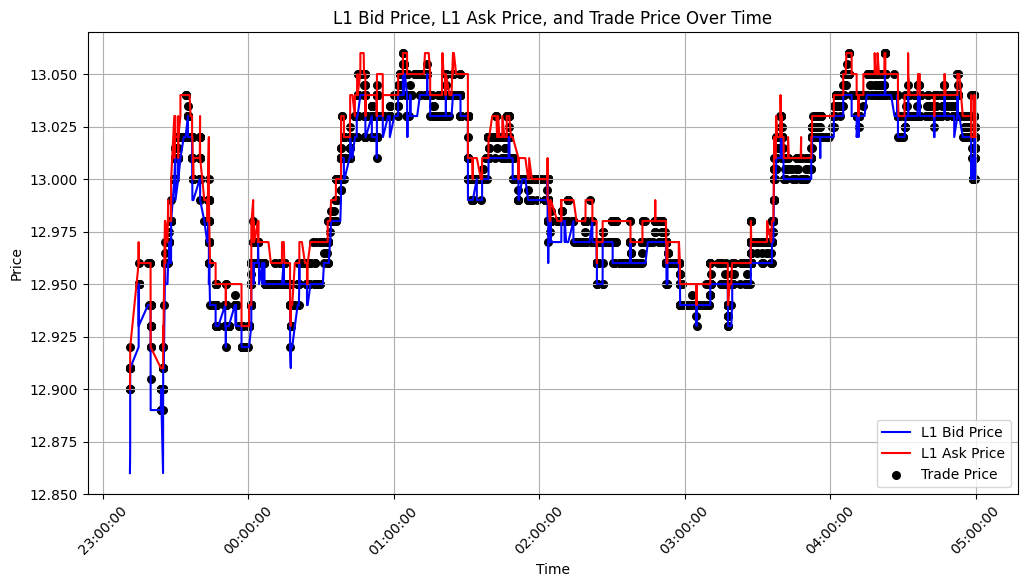

In [12]:
import matplotlib.dates as mdates
plt.figure(figsize=(12,6))

# Plot L1 Bid and Ask Prices (Order Book)
plt.plot(merged_to["Date-Time_x"], merged_to["L1-BidPrice"], label="L1 Bid Price", color="blue", linestyle="-")
plt.plot(merged_to["Date-Time_x"], merged_to["L1-AskPrice"], label="L1 Ask Price", color="red", linestyle="-")

# Overlay Trade Prices as Scatter Points
plt.scatter(merged_to["Date-Time_x"], merged_to["Price"], label="Trade Price", color="black", marker="o", s=30)

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Show HH:MM:SS
plt.xticks(rotation=45)

# Add Labels and Title
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("L1 Bid Price, L1 Ask Price, and Trade Price Over Time")
plt.legend()
plt.grid(True)

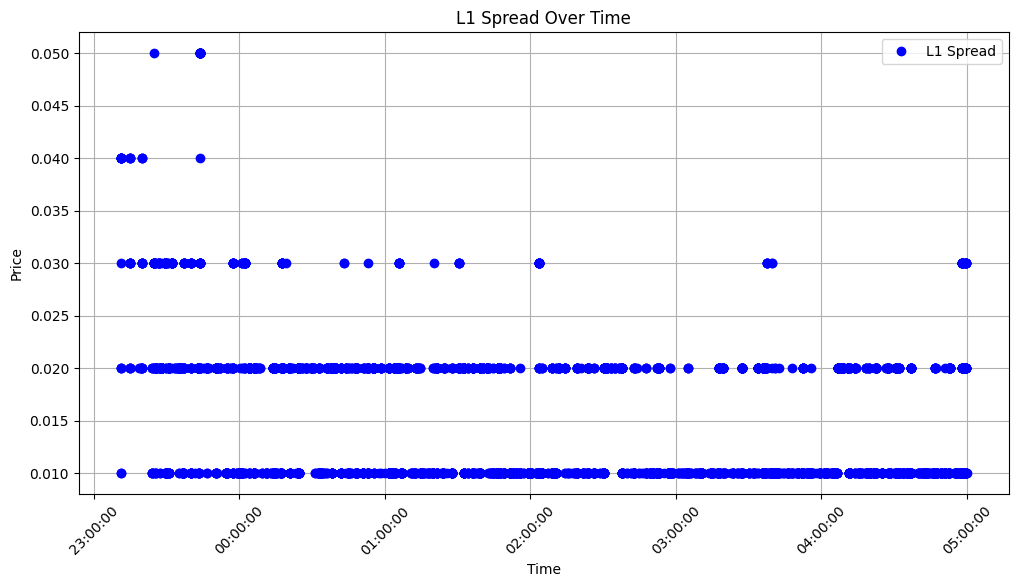

In [41]:
import matplotlib.dates as mdates
plt.figure(figsize=(12,6))

# Plot L1 Bid and Ask Prices (Order Book)
plt.plot(merged_to["Date-Time_x"], merged_to["L1-Spread"], label="L1 Spread", color="blue", marker="o", linestyle='None')


# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Show HH:MM:SS
plt.xticks(rotation=45)

# Add Labels and Title
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("L1 Spread Over Time")
plt.legend()
plt.grid(True)

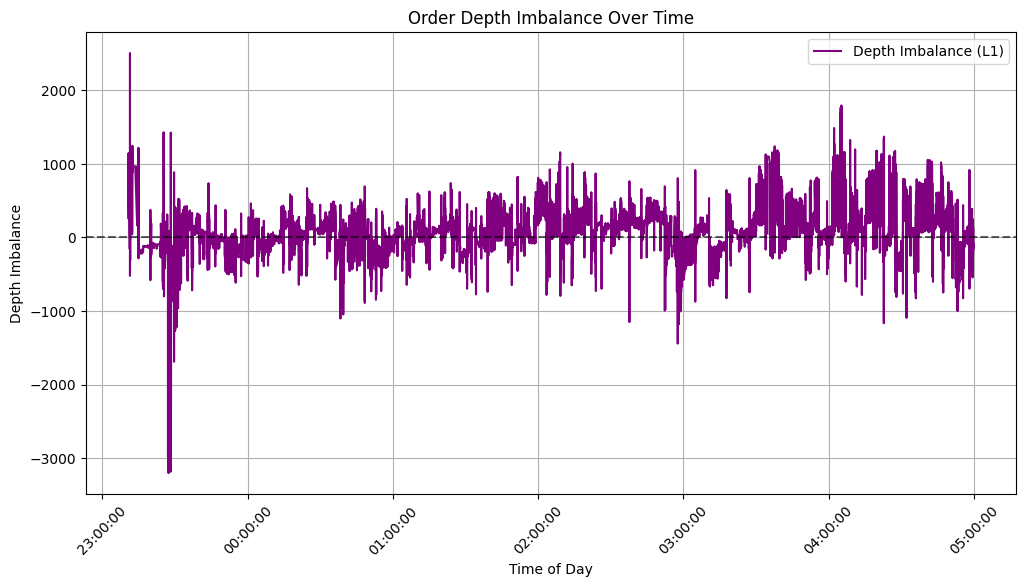

In [13]:
# Select which depth imbalance level to plot (e.g., L1, L5, or aggregate)
depth_col = "L1-DepthImbalance"  # Change this to analyze different levels

# Ensure the DataFrame is sorted by time
lob = lob.sort_values("Date-Time")

# Create the plot
plt.figure(figsize=(12,6))
plt.plot(lob["Date-Time"], lob[depth_col], label="Depth Imbalance (L1)", color="purple", linestyle="-")

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Show HH:MM:SS
plt.xticks(rotation=45)

# Add Labels and Title
plt.xlabel("Time of Day")
plt.ylabel("Depth Imbalance")
plt.title("Order Depth Imbalance Over Time")
plt.axhline(0, color='black', linestyle='--', alpha=0.6)  # Reference line at 0
plt.legend()
plt.grid(True)

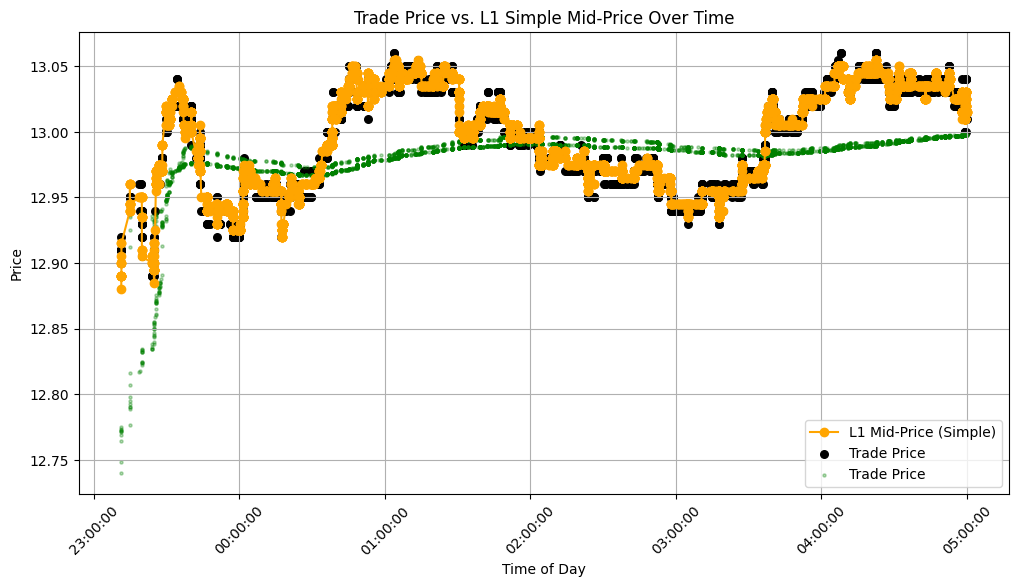

In [37]:
# Create the plot
plt.figure(figsize=(12,6))

# Plot L1 Simple Mid-Price as a continuous line
plt.plot(merged_to["Date-Time_x"], merged_to["L1-MidPrice_Simple"], label="L1 Mid-Price (Simple)", color="orange", marker="o")

# Plot Trade Prices as Scatter Points
plt.scatter(merged_to["Date-Time_x"], merged_to["Price"], label="Trade Price", color="black", marker="o", s=30)

# Plot Trade Prices as Scatter Points
plt.scatter(merged_to["Date-Time_x"], merged_to["Market VWAP"], label="Trade Price", color="green", marker="o", s=5, alpha=0.3)

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Format time as HH:MM:SS
plt.xticks(rotation=45)

# Add Labels and Title
plt.xlabel("Time of Day")
plt.ylabel("Price")
plt.title("Trade Price vs. L1 Simple Mid-Price Over Time")
plt.legend()
plt.grid(True)

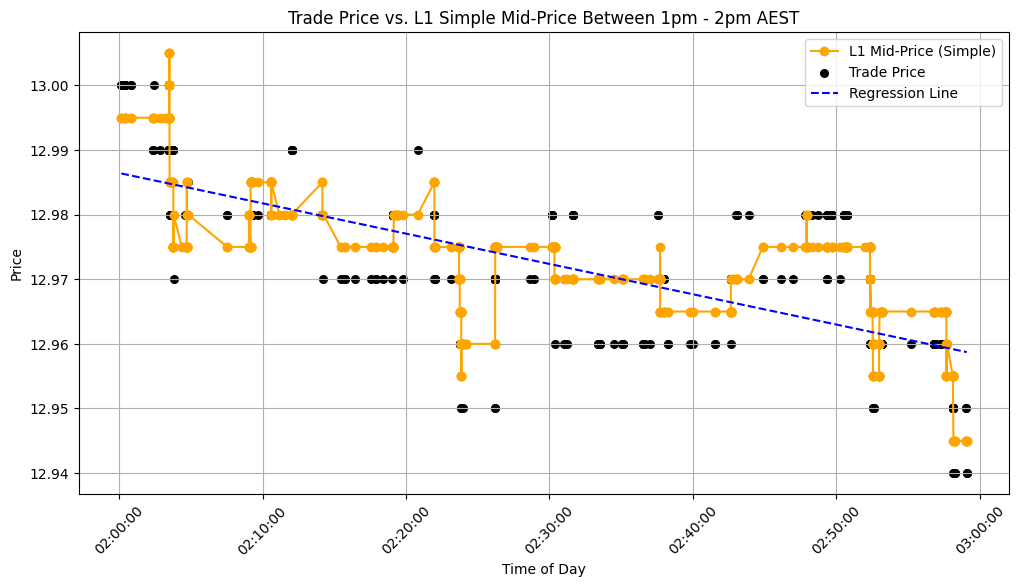

In [26]:
from sklearn.linear_model import LinearRegression


# Create the plot
plt.figure(figsize=(12,6))

# Filter data between 1 PM and 2 PM AEST
spec_m = merged_to[(merged_to["Time_x"] >= time(13, 0, 0)) & 
                   (merged_to["Time_x"] <= time(14, 0, 0))]

# Convert Date-Time_x to numerical values (seconds since start)
time_numeric = (spec_m["Date-Time_x"] - spec_m["Date-Time_x"].min()).dt.total_seconds().values.reshape(-1, 1)
trade_prices = spec_m["Price"].values  # Actual trade prices

# Fit Linear Regression Model
reg = LinearRegression()
reg.fit(time_numeric, trade_prices)

# Predict regression line values
predicted_prices = reg.predict(time_numeric)

# Plot L1 Simple Mid-Price as a continuous line
plt.plot(spec_m["Date-Time_x"], spec_m["L1-MidPrice_Simple"], label="L1 Mid-Price (Simple)", color="orange", marker="o")

# Plot Trade Prices as Scatter Points
plt.scatter(spec_m["Date-Time_x"], spec_m["Price"], label="Trade Price", color="black", marker="o", s=30)

# Plot Regression Line
plt.plot(spec_m["Date-Time_x"], predicted_prices, label="Regression Line", color="blue", linestyle="--")

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Format time as HH:MM:SS
plt.xticks(rotation=45)

# Add Labels and Title
plt.xlabel("Time of Day")
plt.ylabel("Price")
plt.title("Trade Price vs. L1 Simple Mid-Price Between 1pm - 2pm AEST")
plt.legend()
plt.grid(True)

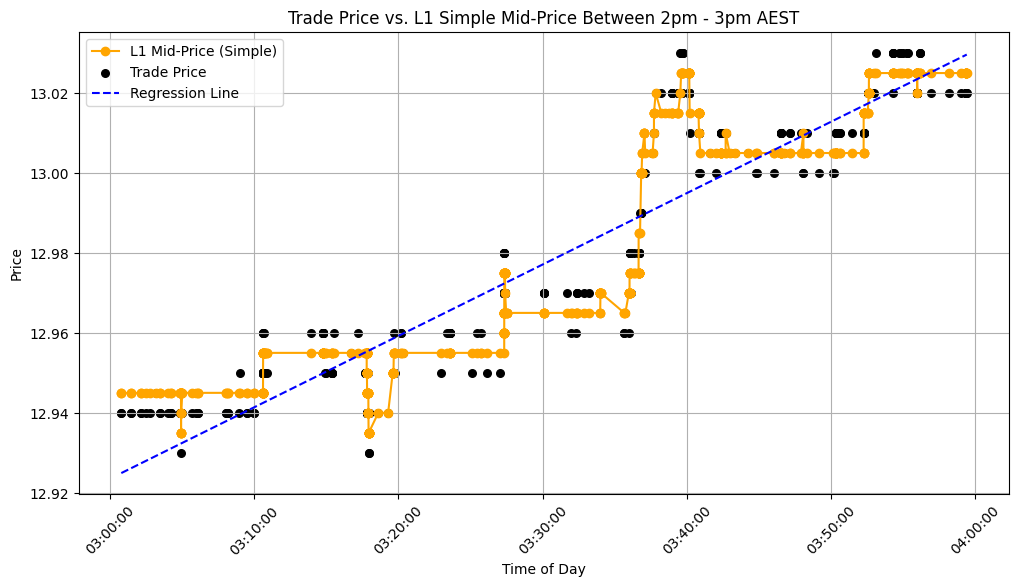

In [27]:
from sklearn.linear_model import LinearRegression


# Create the plot
plt.figure(figsize=(12,6))

# Filter data between 1 PM and 2 PM AEST
spec_m = merged_to[(merged_to["Time_x"] >= time(14, 0, 0)) & 
                   (merged_to["Time_x"] <= time(15, 0, 0))]

# Convert Date-Time_x to numerical values (seconds since start)
time_numeric = (spec_m["Date-Time_x"] - spec_m["Date-Time_x"].min()).dt.total_seconds().values.reshape(-1, 1)
trade_prices = spec_m["Price"].values  # Actual trade prices

# Fit Linear Regression Model
reg = LinearRegression()
reg.fit(time_numeric, trade_prices)

# Predict regression line values
predicted_prices = reg.predict(time_numeric)

# Plot L1 Simple Mid-Price as a continuous line
plt.plot(spec_m["Date-Time_x"], spec_m["L1-MidPrice_Simple"], label="L1 Mid-Price (Simple)", color="orange", marker="o")

# Plot Trade Prices as Scatter Points
plt.scatter(spec_m["Date-Time_x"], spec_m["Price"], label="Trade Price", color="black", marker="o", s=30)

# Plot Regression Line
plt.plot(spec_m["Date-Time_x"], predicted_prices, label="Regression Line", color="blue", linestyle="--")

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))  # Format time as HH:MM:SS
plt.xticks(rotation=45)

# Add Labels and Title
plt.xlabel("Time of Day")
plt.ylabel("Price")
plt.title("Trade Price vs. L1 Simple Mid-Price Between 2pm - 3pm AEST")
plt.legend()
plt.grid(True)

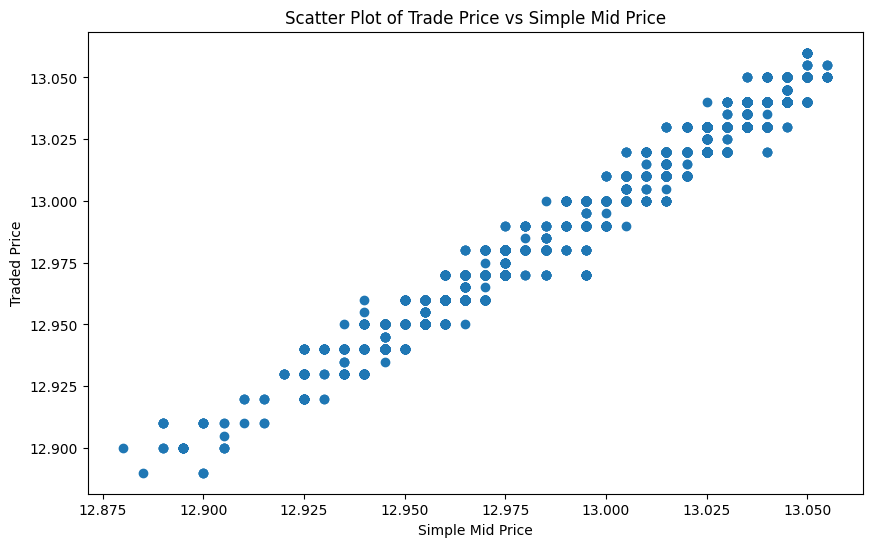

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(y=merged_to["Price"], x=merged_to["L1-MidPrice_Simple"]);
plt.title("Scatter Plot of Trade Price vs Simple Mid Price");
plt.ylabel("Traded Price");
plt.xlabel("Simple Mid Price");

# MidPrice x. Trade Price Metric Calculation

In [15]:
# List of all mid-price columns to compare with traded price
midprice_columns = [f"L{level}-MidPrice_Simple" for level in range(1, 11)] + \
                   [f"L{level}-MidPrice_VW" for level in range(1, 11)] + \
                   [f"L{level}-MidPrice_SCVW" for level in range(1, 11)]

# Create an empty List to store results
metrics_list = []

# Compute statistics for each mid-price type at each level
for col in midprice_columns:
    if col in merged_to.columns:
        trade_prices = merged_to["Price"]  # Actual traded prices
        mid_prices = merged_to[col]  # Mid-price at given level

        # Compute error metrics
        diff = trade_prices - mid_prices
        mae = np.mean(np.abs(diff))
        mse = np.mean(diff ** 2)
        rmse = np.sqrt(mse)
        mean_diff = np.mean(diff)
        tracking_error = np.std(diff)
        correlation = np.corrcoef(trade_prices, mid_prices)[0, 1] if len(trade_prices) > 1 else np.nan
        te_check = np.sqrt(mse - mean_diff ** 2)

        # Store results in DataFrame
        metrics_list.append({
            "Level": col.split("-")[0],  # Extract L1, L2, etc.
            "Type": col.split("-")[-1],  # Extract Simple, VW, SCVW
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "Mean Difference": mean_diff,
            "Tracking Error": tracking_error,
            "Correlation": correlation,
            "TE Check": te_check
        })

metrics_df = pd.DataFrame(metrics_list)

In [16]:
metrics_df

,Level,Type,MAE,MSE,RMSE,Mean Difference,Tracking Error,Correlation,TE Check
0,L1,MidPrice_Simple,0.004812,0.000036,0.005986,-0.000670,0.005949,0.987315,0.005949
1,L2,MidPrice_Simple,0.004817,0.000036,0.006019,-0.000655,0.005983,0.987200,0.005983
2,L3,MidPrice_Simple,0.004846,0.000037,0.006078,-0.000685,0.006039,0.986965,0.006039
3,L4,MidPrice_Simple,0.004858,0.000037,0.006071,-0.000716,0.006028,0.986991,0.006028
4,L5,MidPrice_Simple,0.004875,0.000037,0.006107,-0.000774,0.006058,0.986849,0.006058
5,L6,MidPrice_Simple,0.004905,0.000038,0.006172,-0.000803,0.006120,0.986572,0.006120
6,L7,MidPrice_Simple,0.004958,0.000039,0.006263,-0.000816,0.006210,0.986196,0.006210
7,L8,MidPrice_Simple,0.005007,0.000041,0.006375,-0.000842,0.006319,0.985714,0.006319
8,L9,MidPrice_Simple,0.004995,0.000040,0.006314,-0.000816,0.006261,NaN,0.006261
9,L10,MidPrice_Simple,0.004958,0.000039,0.006240,-0.000784,0.006191,NaN,0.006191


# Linear Regressions

In [35]:
# Filter data between 1 PM and 2 PM AEST
spec_m = merged_to[(merged_to["Time_x"] >= time(13, 0, 0)) & 
                   (merged_to["Time_x"] <= time(14, 0, 0))]

# Convert Date-Time_x to numerical values (seconds since start)
time_numeric = (spec_m["Date-Time_x"] - spec_m["Date-Time_x"].min()).dt.total_seconds().values.reshape(-1, 1)
trade_prices = spec_m["Price"].values  # Actual trade prices

# Add constant (intercept) to the feature
X = sm.add_constant(time_numeric)  # Adds column of ones for intercept
y = trade_prices

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print full regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     813.1
Date:                Fri, 07 Mar 2025   Prob (F-statistic):          4.99e-119
Time:                        16:17:29   Log-Likelihood:                 2354.6
No. Observations:                 697   AIC:                            -4705.
Df Residuals:                     695   BIC:                            -4696.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9864      0.001   2.21e+04      0.0

In [34]:
# Filter data between 1 PM and 2 PM AEST
spec_m = merged_to[(merged_to["Time_x"] >= time(14, 0, 0)) & 
                   (merged_to["Time_x"] <= time(15, 0, 0))]

# Convert Date-Time_x to numerical values (seconds since start)
time_numeric = (spec_m["Date-Time_x"] - spec_m["Date-Time_x"].min()).dt.total_seconds().values.reshape(-1, 1)
trade_prices = spec_m["Price"].values  # Actual trade prices

# Add constant (intercept) to the feature
X = sm.add_constant(time_numeric)  # Adds column of ones for intercept
y = trade_prices

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print full regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     3917.
Date:                Fri, 07 Mar 2025   Prob (F-statistic):          6.41e-281
Time:                        16:16:36   Log-Likelihood:                 2017.2
No. Observations:                 667   AIC:                            -4030.
Df Residuals:                     665   BIC:                            -4021.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9249      0.001   1.35e+04      0.0